# Precompute pairwise distance matrices

We need pairwise distances matrices for triplet sampling. These pairwise distance *could* be computed on-line during batch preparation, but this would result in many triplets being rejected and thus be slow.

Therefore, we here precompute pairwise distance matrices and save them to file.

Currently, the pairwise distances are implemened for the following metrics:
- CAE: distances between the encodings given by the convolutional autoencoder. This requires a trained encoder part of the CAE (in `<root>/output/models/encoder.h5`).

- Age: pairwise distances of the age in months

- Wasserstein distance: pairwise Wasserstein distances between the histograms of the images.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys, glob
import numpy as np
import pandas as pd
from IPython.display import SVG 

In [2]:
# reload my utilities at every cell execution 
%load_ext autoreload
%autoreload 2
# get absolute path of module (root)
module_path = os.path.abspath(os.path.join('../../src'))

# add to PYTHONPATH
if module_path not in sys.path:
    sys.path.append(module_path)
    #print(sys.path)

# import module
from networks import TripletNetwork
import image_similarity_metrics

# Get image data

In [3]:
h, w = 128, 256

In [4]:
def read_image(path):
    from imageio import imread
    from skimage.transform import resize
    try:
        img = imread(path).astype(np.float32)
    except:
        return None
    if img.ndim != 2:
        return None
    img /= 255.
    img = resize(img, (h,w))
    #img = np.flipud(img)
    #print(img.shape)
    return img

In [5]:
data_folder = '/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/'

['cae_distance', 'earth_movers_distance', 'pixel_distance', 'ssim_distance']
cae_distance = 17.741230011
earth_movers_distance = 0.455856323
pixel_distance = 0.005082074
ssim_distance = 0.623654926


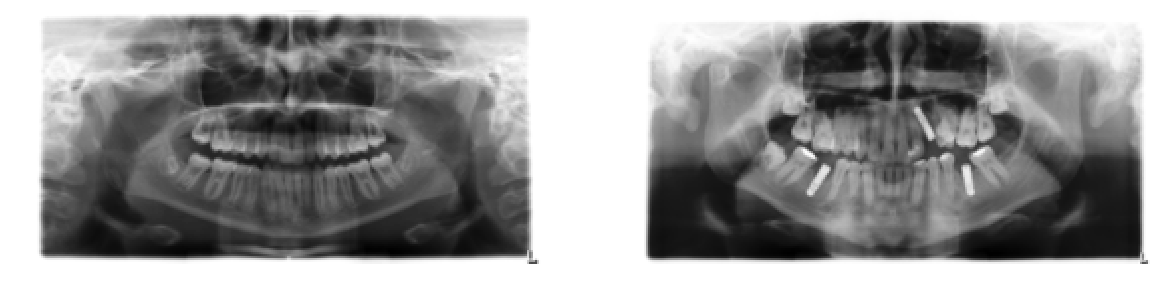

In [6]:
filenames = sorted(glob.glob(os.path.join(data_folder, '*.png')))

# choose two images at random
random_pair = np.random.choice(filenames, size=2)
img_pair = [read_image(s) for s in random_pair]

# plot the images
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(np.squeeze(img_pair[0]), cmap='gray')
ax[1].imshow(np.squeeze(img_pair[1]), cmap='gray')
for a in ax: a.axis('off')

# compute all distance metrics
distance_metrics = [f for f in dir(image_similarity_metrics) if f.endswith('_distance')]
print(distance_metrics)
for metric in distance_metrics:
    value = getattr(image_similarity_metrics, metric)(*img_pair)
    print(f'{metric} = {value:.9f}')


# Load dataframe

In [4]:
df = pd.read_csv('/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/PatientImages_with_sex.csv', sep=';')
df.head()

ID    DWID      oldDWID  Age Sex Type  Region  \
0  92FE07313356752620BC92F1AE1F0A   132.0          132  110   W   XP       1   
1  D1D604E35202C63BB6C3A06C35CE4F   150.0          150  285   W   XP       1   
2  6E43C46B1A9DD0F8F7DBE24D3676E4   333.0  DW000000333  219   M   XP       2   
3  6E43C46B1A9DD0F8F7DBE24D3676E4   333.0  DW000000333  287   M   XP       1   
4  D0357FCD49DEFF620C53AC9D5A2E41  1074.0         1074  269   -   XP       2   

                      OldFile                             NewFile  
0  P_0016\P_001604\002651.TIF  1A999A747CA732BD8ADD863E7E0257.tif  
1  P_0227\P_022780\065417.TIF  A5FE53884CB317CDC67A70448DB8AF.tif  
2  P_0205\P_020582\057693.TIF  EEBB2E845B2F34B03AFDC0C4A02C73.tif  
3  P_0205\P_020582\189182.TIF  E733B5CA820CA8A9C45CB2DFA62439.tif  
4  P_0048\P_004895\007445.TIF  88C63B9D118993E5E6A1C0144C5CF2.tif

# Calculate pairwise distances for various metrics

In [5]:
import sklearn
print(sklearn.__version__)

0.21.1


In [9]:
#from scipy.spatial.distance import squareform, pdist # single threaded
from sklearn.metrics.pairwise import pairwise_distances # multithreaded, BUT SOMETIMES DOES NOT RETURN THE WHOLE MATRIX!!

## Pairwise distances for *cae_distance*

- precalculate encodings for all images
    - chunk list of filenames in batches
    - get encodings for each batch

In [10]:
# compute encoding for all samples
from image_similarity_metrics import cae_encoding
from tqdm import tqdm as tqdm

from keras.models import load_model
encoder = load_model('../../output/models/encoder.h5')

def chunker(seq, size):
    '''https://stackoverflow.com/a/434328'''
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_encodings(fns):
    fns2 = [fn.split('.')[0]+'.png' for fn in fns]
    paths = [os.path.join('/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/', fn) for fn in fns2]
    imgs = np.array([read_image(fn) for fn in paths])
    imgs2= [x      for    x in           imgs  if x is not None] # filter Nones
    fns3 = [fns[i] for i, x in enumerate(imgs) if x is not None] # filter Nones from fns
    imgs = np.expand_dims(imgs2, -1)
    #print(imgs.shape)
    encodings = encoder.predict(imgs)
    encodings = encodings.reshape(encodings.shape[0], -1)
    #print(encodings.shape)
    return fns3, encodings

batch_size=64
filenames_batches = chunker(df['NewFile'].values, batch_size)
filenames_encodings = [get_encodings(fns) for fns in tqdm(filenames_batches)]
#from joblib import Parallel, delayed
#filenames_encodings = Parallel(n_jobs=-1)(delayed(get_encodings)(fns) for fns in tqdm(filenames_batches))
filenames, encodings = map(list,zip(*filenames_encodings))


364it [00:54,  6.72it/s]


In [11]:
# flatten list of filenames
filenames = np.array([item for sublist in filenames for item in sublist])
# flatten list of encodings into ndarray
encodings = np.vstack( [*encodings] )

- add encodings to dataframe (while dropping entries without valid images)

In [12]:
# add encodings to dataframe

# create new dataframe
values_dict = dict(zip(filenames, encodings))
df2 = pd.DataFrame.from_dict(list(values_dict.items()))
df2.columns = ['NewFile', 'CAE encoding']

# merge new dataframe with previous one
df3 = pd.merge(df, df2, how='inner', on='NewFile')
# remove all entries with NaN CAE encoding
df = df3.dropna(subset=['CAE encoding'])

#del(df2)
#del(df3)

In [13]:
df.head(2)

ID   DWID oldDWID  Age Sex Type  Region  \
0  92FE07313356752620BC92F1AE1F0A  132.0     132  110   W   XP       1   
1  D1D604E35202C63BB6C3A06C35CE4F  150.0     150  285   W   XP       1   

                      OldFile                             NewFile  \
0  P_0016\P_001604\002651.TIF  1A999A747CA732BD8ADD863E7E0257.tif   
1  P_0227\P_022780\065417.TIF  A5FE53884CB317CDC67A70448DB8AF.tif   

                                        CAE encoding  
0  [0.51059926, 0.099028744, 0.4429211, 0.4885499...  
1  [0.518963, 0.17154056, 0.40186402, 0.47656566,...

- calculate the pairwise distances

In [14]:
# pairwise Euclidean distances between CAE encodings
x = df['CAE encoding'].values
x = np.array([i for i in x]) # make into 2D array
print(x.shape)
# compute pairwise distances
#pdist_cae = pairwise_distances(x, metric='euclidean', n_jobs=-1)
from scipy.spatial.distance import squareform, pdist # single threaded
pdist_cae = squareform(pdist(x, metric='euclidean'))
print(pdist_cae.shape)

# save to file
np.save('../../output/data/pdist_cae.npy', pdist_cae)

(18285, 1024)
(18285, 18285)


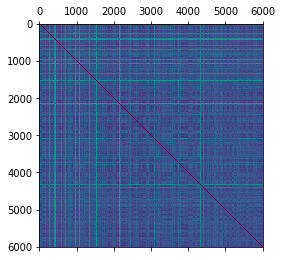

In [15]:
# plot matrix
plt.matshow(pdist_cae[:6000,:6000])

In [16]:
del(df2)
del(df3)

## Pairwise distances for *age*

In [17]:
x = df['Age'].values
x = x[..., np.newaxis] # make 2D

# compute pairwise distances
#pdist_age = pairwise_distances(x, n_jobs=1)
pdist_age = squareform(pdist(x, metric='euclidean'))

# save to file
np.save('../../output/data/pdist_age.npy', pdist_age.astype(np.float32))
# plot matrix
#plt.matshow(pdist_age)
del(x)

In [18]:
del(pdist_age)
del(pdist_cae)
del(pdist_cae2)


NameError: name 'pdist_cae2' is not defined

In [ ]:
#del(encodings)
#del(df2)
#del(df3)
#del(x)

In [ ]:
del(fig)
del(ax)

## Pairwise distances for *Wasserstein distance*

- precalculate histograms for each image

In [19]:
def get_histo(fn):
    fn = fn.split('.')[0]+'.png'
    path = os.path.join('/data/dl-IMAGEDATA/TEETH-AGE-ESTIMATION/thumbnails/', fn)
    print(path)
    img = read_image(path)
    print(img)
    return image_similarity_metrics.get_histogram((img*255).astype(np.uint8))

In [20]:
#for i, row in df.iterrows():
#    print(row['NewFile'])
#    print(row['CAE encoding'])
#    get_histo(row['NewFile'])

#histograms = [get_histo(fn) for fn in df['NewFile']]
from joblib import Parallel, delayed
histograms = Parallel(n_jobs=-1)(delayed(get_histo)(fn) for fn in tqdm(df['NewFile']))
# add to dataframe
df['Histogram'] = histograms
df.head()
del(histograms)

 81%|████████▏ | 14882/18285 [01:48<00:24, 137.12it/s]

KeyboardInterrupt: 

In [ ]:
df.to_csv('../../output/data/dataframe_triplet.csv')

In [ ]:
df.to_hdf('../../output/data/dataframe_triplet.h5', key='df', mode='w')

In [ ]:
# pairwise Wasserstein distances between histograms
x = df['Histogram'].values
x = np.array([i for i in x]) # make into 2D array
print(x.shape)
from scipy.stats import wasserstein_distance
#pdist_wasserstein = pairwise_distances(x, metric=wasserstein_distance, n_jobs=-1)
pdist_wasserstein = squareform(pdist(x, metric=wasserstein_distance))

np.save('../../output/data/pdist_wasserstein.npy', pdist_wasserstein.astype(np.float32))

#plt.matshow(pdist_wasserstein)